In [1]:
import torch
from utils import DataManager, dataset_sizes, collect_training_data, compute_token_counts, compute_statistics, compute_average_accuracies
import matplotlib.pyplot as plt
from probes import CCSProbe, TTPD, LRProbe
import numpy as np
from transformers import AutoTokenizer, LlamaTokenizer
import os
from collections import defaultdict
import configparser
from tqdm import tqdm

/export/home/lbuerger/miniconda3/envs/truth_is_universal/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# hyperparameters
model_family = 'Llama3' # options are 'Llama3', 'Llama2' or 'Gemma'
model_size = '8B'
model_type = 'chat' # options are 'chat' or 'base'
layer = 12 # layer from which to extract activations

device = 'cuda:4' if torch.cuda.is_available() else 'cpu' # gpu speeds up CCS training a fair bit but is not required
device

'cuda:4'

In [3]:
# load tokenizer 
config = configparser.ConfigParser()
config.read('config.ini')
model_path = os.path.join(config[model_family]['weights_directory'], 
                          config[model_family][f'{model_size}_{model_type}_subdir'])
if model_family == "Llama":
    tokenizer = LlamaTokenizer.from_pretrained(model_path)
else:
    tokenizer = AutoTokenizer.from_pretrained(model_path)

# define datasets used for training
train_sets = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans", "inventors", "neg_inventors", "animal_class",
                  "neg_animal_class", "element_symb", "neg_element_symb", "facts", "neg_facts"]
# get size of each training dataset to include an equal number of statements from each topic in training data
train_set_sizes = dataset_sizes(train_sets) 

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### Unseen topics

In [4]:
# compare TTPD, LR and CCS on topic-specific datasets
probe_types = [TTPD, LRProbe, CCSProbe]
results = {TTPD: defaultdict(list), LRProbe: defaultdict(list), CCSProbe: defaultdict(list)}
num_iter = 20

total_iterations = len(probe_types) * num_iter * len(train_sets)
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            indices = np.arange(0, 12, 2)
            for i in indices:
                cv_train_sets = np.delete(np.array(train_sets), [i, i+1], axis=0)
                # load training data
                acts_centered, acts, labels, polarities, token_counts = collect_training_data(cv_train_sets, train_set_sizes, model_family, model_size, model_type,
                                                                                            layer, return_token_counts=True, tokenizer=tokenizer)
                if probe_type == TTPD:
                    probe = TTPD.from_data(acts_centered, acts, labels, polarities, token_counts)
                if probe_type == LRProbe:
                    probe = LRProbe.from_data(acts, labels)
                if probe_type == CCSProbe:
                    acts_affirm = acts[polarities == 1.0]
                    acts_neg = acts[polarities == -1.0]
                    labels_affirm = labels[polarities == 1.0]
                    mean_affirm = torch.mean(acts_affirm, dim=0) 
                    mean_neg = torch.mean(acts_neg, dim=0)
                    acts_affirm = acts_affirm - mean_affirm
                    acts_neg = acts_neg - mean_neg
                    probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')

                # evaluate classification accuracy on held out datasets
                dm = DataManager()
                for j in range(0,2):
                    dm.add_dataset(train_sets[i+j], model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                    acts, labels = dm.data[train_sets[i+j]]
                    
                    # classifier specific predictions
                    if probe_type == CCSProbe:
                        if j == 0:
                            acts = acts - mean_affirm
                        if j == 1:
                            acts = acts - mean_neg
                    if probe_type == TTPD:
                        token_count = compute_token_counts(train_sets[i+j], tokenizer)
                        predictions = probe.pred(acts, token_count)
                    else:
                        predictions = probe.pred(acts)
                    
                    results[probe_type][train_sets[i+j]].append((predictions == labels).float().mean().item())
                    pbar.update(1)

stat_results = compute_statistics(results)

# Compute mean accuracies and standard deviations for each probe type
probe_accuracies = compute_average_accuracies(results, num_iter)

for probe_type, stats in probe_accuracies.items():
    print(f"{probe_type}:")
    print(f"  Mean Accuracy: {stats['mean']*100:.2f}%")
    print(f"  Standard Deviation of the mean accuracy: {stats['std_dev']*100:.2f}%")

Training and evaluating classifiers:  67%|██████▋   | 480/720 [05:21<01:30,  2.66it/s]/export/home/lbuerger/miniconda3/envs/truth_is_universal/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Training and evaluating classifiers: 100%|██████████| 720/720 [09:55<00:00,  1.21it/s]

TTPD:
  Mean Accuracy: 93.90%
  Standard Deviation of the mean accuracy: 0.19%
LRProbe:
  Mean Accuracy: 94.66%
  Standard Deviation of the mean accuracy: 0.77%
CCSProbe:
  Mean Accuracy: 83.92%
  Standard Deviation of the mean accuracy: 6.33%


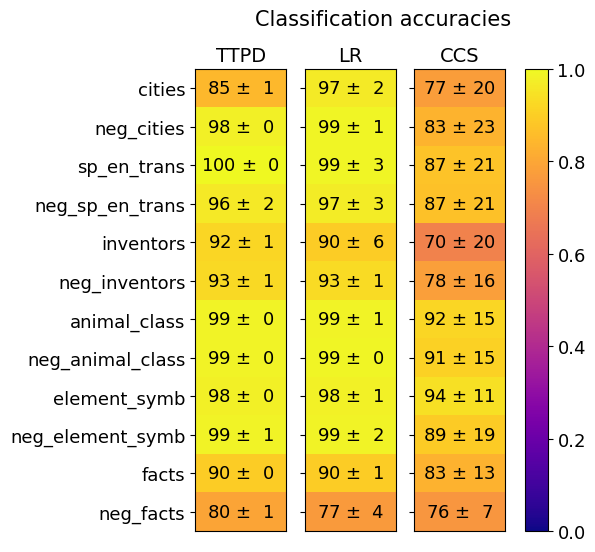

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(5, 6), ncols=3)
titles = ["TTPD", "LR", "CCS"]

for t, (ax, key) in enumerate(zip((ax1, ax2, ax3), (TTPD, LRProbe, CCSProbe))):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in train_sets]
    grid_std = [[stat_results[key]['std'][dataset]] for dataset in train_sets]
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    for i, row in enumerate(grid):
        for j, val in enumerate(row):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d} $\pm$ {round(grid_std[i][j] * 100):2d}', ha='center', va='center', fontsize=13)
    
    ax.set_yticks(range(len(train_sets)))
    ax.set_xticks([])
    
    ax.set_title(titles[t], fontsize=14)

ax1.set_yticklabels(train_sets, fontsize=13)
ax2.set_yticklabels([])
ax3.set_yticklabels([])

cbar = fig.colorbar(im, ax=[ax1, ax2, ax3])
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification accuracies", fontsize=15)
plt.show()

### Unseen types of statements

In [6]:
# compare TTPD, LR and CCS on logical conjunctions and disjunctions
val_sets = ["cities_conj", "cities_disj", "sp_en_trans_conj","sp_en_trans_disj",
             "inventors_conj", "inventors_disj", "animal_class_conj", "animal_class_disj",
               "element_symb_conj", "element_symb_disj", "facts_conj", "facts_disj",
            "common_claim_true_false", "counterfact_true_false"]


probe_types = [TTPD, LRProbe, CCSProbe]
results = {TTPD: defaultdict(list), LRProbe: defaultdict(list), CCSProbe: defaultdict(list)}
num_iter = 20

total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities, token_counts = collect_training_data(train_sets, train_set_sizes, model_family, model_size, model_type,
                                                                                        layer, return_token_counts=True, tokenizer=tokenizer)
            if probe_type == TTPD:
                probe = TTPD.from_data(acts_centered, acts, labels, polarities, token_counts)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')

            # evaluate classification accuracy on validation datasets
            dm = DataManager()
            for val_set in val_sets:
                dm.add_dataset(val_set, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
                acts, labels = dm.data[val_set]
                
                # classifier specific predictions
                if probe_type == CCSProbe:
                    acts = acts - (mean_affirm + mean_neg)/2
                if probe_type == TTPD:
                    token_count = compute_token_counts(val_set, tokenizer)
                    predictions = probe.pred(acts, token_count)
                else:
                    predictions = probe.pred(acts)
                
                results[probe_type][val_set].append((predictions == labels).float().mean().item())
            pbar.update(1)

stat_results = compute_statistics(results)

# Compute mean accuracies and standard deviations for each probe type
probe_accuracies = compute_average_accuracies(results, num_iter)

for probe_type, stats in probe_accuracies.items():
    print(f"{probe_type}:")
    print(f"  Mean Accuracy: {stats['mean']*100:.2f}%")
    print(f"  Standard Deviation of the mean accuracy: {stats['std_dev']*100:.2f}%")

Training and evaluating classifiers: 100%|██████████| 60/60 [05:34<00:00,  5.57s/it]

TTPD:
  Mean Accuracy: 75.32%
  Standard Deviation of the mean accuracy: 0.22%
LRProbe:
  Mean Accuracy: 71.44%
  Standard Deviation of the mean accuracy: 2.01%
CCSProbe:
  Mean Accuracy: 71.12%
  Standard Deviation of the mean accuracy: 4.46%


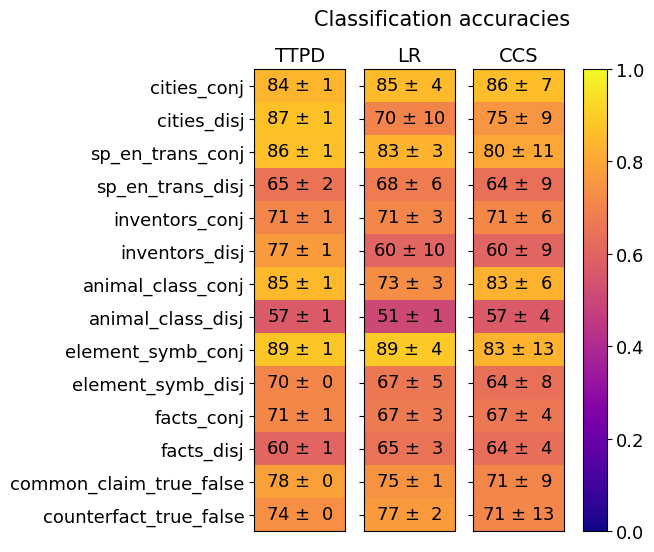

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(5, 6), ncols=3)
titles = ["TTPD", "LR", "CCS"]

for t, (ax, key) in enumerate(zip((ax1, ax2, ax3), (TTPD, LRProbe, CCSProbe))):
    grid = [[stat_results[key]['mean'][dataset]] for dataset in val_sets]
    grid_std = [[stat_results[key]['std'][dataset]] for dataset in val_sets]
    im = ax.imshow(grid, vmin=0, vmax=1, cmap='plasma', aspect='auto')
    
    for i, row in enumerate(grid):
        for j, val in enumerate(row):
            ax.text(j, i, f'{round(grid[i][j] * 100):2d} $\pm$ {round(grid_std[i][j] * 100):2d}', ha='center', va='center', fontsize=13)
    
    ax.set_yticks(range(len(val_sets)))
    ax.set_xticks([])
    
    ax.set_title(titles[t], fontsize=14)

ax1.set_yticklabels(val_sets, fontsize=13)
ax2.set_yticklabels([])
ax3.set_yticklabels([])

cbar = fig.colorbar(im, ax=[ax1, ax2, ax3])
cbar.ax.tick_params(labelsize=13)

fig.suptitle("Classification accuracies", fontsize=15)
plt.show()

### Real world scenarios / lies

In [8]:
probe_types = [TTPD, LRProbe, CCSProbe]
results = {TTPD: [], LRProbe: [], CCSProbe: []}
num_iter = 100

total_iterations = len(probe_types) * num_iter
with tqdm(total=total_iterations, desc="Training and evaluating classifiers") as pbar: # progress bar
    for probe_type in probe_types:
        for n in range(num_iter):
            # load training data
            acts_centered, acts, labels, polarities, token_counts = collect_training_data(train_sets, train_set_sizes, model_family, model_size, model_type,
                                                                                        layer, return_token_counts=True, tokenizer=tokenizer)
            if probe_type == TTPD:
                probe = TTPD.from_data(acts_centered, acts, labels, polarities, token_counts)
            if probe_type == LRProbe:
                probe = LRProbe.from_data(acts, labels)
            if probe_type == CCSProbe:
                acts_affirm = acts[polarities == 1.0]
                acts_neg = acts[polarities == -1.0]
                labels_affirm = labels[polarities == 1.0]
                mean_affirm = torch.mean(acts_affirm, dim=0) 
                mean_neg = torch.mean(acts_neg, dim=0)
                acts_affirm = acts_affirm - mean_affirm
                acts_neg = acts_neg - mean_neg
                probe = CCSProbe.from_data(acts_affirm, acts_neg, labels_affirm, device=device).to('cpu')

            # evaluate classification accuracy on real world scenarios
            dm = DataManager()
            real_world_dataset = "real_world_scenarios/all_unambiguous_replies"
            dm.add_dataset(real_world_dataset, model_family, model_size, model_type, layer, split=None, center=False, device='cpu')
            acts, labels = dm.data[real_world_dataset]
            
            # classifier specific predictions
            if probe_type == CCSProbe:
                acts = acts - (mean_affirm + mean_neg)/2
            if probe_type == TTPD:
                token_count = compute_token_counts(real_world_dataset, tokenizer)
                predictions = probe.pred(acts, token_count)
            else:
                predictions = probe.pred(acts)
            
            results[probe_type].append((predictions == labels).float().mean().item())
            pbar.update(1)

for probe_type in probe_types:
    mean = np.mean(results[probe_type])
    std = np.std(results[probe_type])
    print(f"{probe_type.__name__}:")
    print(f"  Mean Accuracy: {mean*100:.2f}%")
    print(f"  Standard Deviation: {std*100:.2f}%")

Training and evaluating classifiers: 100%|██████████| 300/300 [06:57<00:00,  1.39s/it]

TTPD:
  Mean Accuracy: 94.75%
  Standard Deviation: 1.93%
LRProbe:
  Mean Accuracy: 77.55%
  Standard Deviation: 8.09%
CCSProbe:
  Mean Accuracy: 73.80%
  Standard Deviation: 13.80%
